In [2]:
import pickle
from mcar_sarsa_semigrad_TileSutton import ValueFunction, run_episode, getOptimalAction, run_rollout, solve_mdp, evaluate_softmax_policy, evaluate_policy
import gym
import time
import numpy as np 
import random

This code only works for MountainCar right now since I'm using specific Tile Coding software from Rick Sutton but we should be able to plug in any RL algorithm.

In [3]:
env = gym.make('MountainCar-v0')
#set seeds for now
#seed = 1234
#np.random.seed(seed)
#random.seed(seed)
#env.seed(seed)

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


Generate learning trajectories using Tile Coding. I don't stop MCar after 200 steps but let it go up to 2000 steps.

In [18]:
num_demos = 5

numOfTilings = 8
alpha = 0.5
n = 1


# use optimistic initial value, so it's ok to set epsilon to 0
EPSILON = 0.0
discount = 0.999 #using high discount factor

vFunction = ValueFunction(alpha, numOfTilings)
demonstrations = []
learning_returns = []
for i in range(num_demos):
    r, s, steps = run_episode(env, vFunction, n, False, EPSILON, max_time = 2000)

    demonstrations.append(s)
    learning_returns.append(r)
    print(r)
    
    
print("ave return = {}".format(np.mean(learning_returns)))



-2000.0
-393.0
-743.0
-445.0
-421.0
ave return = -800.4


Below are some helper functions for getting argmax action from TileCoding value function and normalizing observations to range [0,1].

In [20]:
def argmax_value(state, env):
    values = [valueFunction.value(state[0], state[1], a) for a in range(env.action_space.n)]
    return np.argmax(values)

In [21]:
def normalize_state(obs):
    obs_highs = env.observation_space.high
    obs_lows = env.observation_space.low
    return (obs - obs_lows) / (obs_highs - obs_lows)
    

Normalize observations

In [22]:
normed_demos = [[normalize_state(s) for s in d]for d in demonstrations]
demonstrations = normed_demos

Now I want to build a neural network to predict the reward the learner is trying to optimize. I'm using a pretty simple network since the state space is just 2-d (pos, vel) and there are not many demonstrations.

In [23]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        ##self.scalar = nn.Linear(1,1, bias=False)
        self.fc1 = nn.Linear(2,32)
        #self.fc2 = nn.Linear(32,32)
        self.fc3 = nn.Linear(32,1) #return scalar reward value, linear combination of 32 features.
    
    def cum_return(self, traj):
        '''calculate cumulative return of trajectory'''
        sum_rewards = 0
        for x in traj:
            #compute forward pass of reward network
            x = F.relu(self.fc1(x))
        #    x = F.relu(self.fc2(x))
            r = self.fc3(x)
            sum_rewards += r
        ##    y = self.scalar(torch.ones(1))
        ##    sum_rewards += y
        #print(sum_rewards)
        return sum_rewards
        
            
    
    def forward(self, traj_i, traj_j):
        '''compute cumulative return for each trajectory and return logits'''
        #print([self.cum_return(traj_i), self.cum_return(traj_j)])
        return torch.cat([self.cum_return(traj_i), self.cum_return(traj_j)])
    


Now we train the network. I'm just going to do it one by one for now. Could adapt it for minibatches to get better gradients

In [24]:
def learn_reward(reward_network, optimizer, trajectories, num_iter):
    loss_criterion = nn.CrossEntropyLoss()
    #print(training_data[0])
    cum_loss = 0.0
    for epoch in range(num_iter):
        #pick two random trajectories, traj_i and traj_j such that i > j
        j = np.random.randint(len(trajectories)-1) #make sure there is at least one later trajectory
        i = np.random.randint(j+1,len(trajectories))
        #print(i,j)
        #traj_i = np.array([[d[0]] for d in trajectories[i]])
        #traj_j = np.array([[d[0]] for d in trajectories[j]])
        traj_i = np.array(trajectories[i])
        traj_j = np.array(trajectories[j])
        labels = np.array([0])
        traj_i = torch.from_numpy(traj_i).float()
        traj_j = torch.from_numpy(traj_j).float()
        labels = torch.from_numpy(labels)
        
        #zero out gradient
        optimizer.zero_grad()

        #forward + backward + optimize
        outputs = reward_network.forward(traj_i, traj_j).unsqueeze(0)
        #print(outputs)
        #print(labels)
        loss = loss_criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        #print stats to see if learning
        item_loss = loss.item()
        cum_loss += item_loss
        if epoch % 100 == 99:
            #with torch.no_grad():
            #    print(torch.cat([reward_network.cum_return(torch.from_numpy(np.array(traj)).float()) for traj in trajectories]))
            print(epoch, cum_loss / 100)
            cum_loss = 0.0
    print("finished training")



        
    

Now we create a reward network and optimize it using the training data.

In [26]:
reward = Net()
import torch.optim as optim
optimizer = optim.SGD(reward.parameters(), lr = 0.0001, momentum=0.9)
learn_reward(reward, optimizer, demonstrations, 500)

99 56.91188086271286
199 12.703585705757142
299 12.671289551258088
399 11.018318490982056
499 23.02617594718933
finished training


Print out learned return for all demos. should be roughly increasing

In [27]:
with torch.no_grad():
    print(torch.cat([reward.cum_return(torch.from_numpy(np.array(traj)).float()) for traj in demonstrations]))

tensor([-2150.3616,  -426.8924,  -800.4850,  -481.1498,  -454.7668])


Look at reward heatmap over position and velocity

[[-0.93366033 -0.93911934 -0.94457829 ... -0.97691035 -0.97513956
  -0.97336882]
 [-0.9381938  -0.94365275 -0.94911176 ... -0.98041999 -0.9786492
  -0.97687846]
 [-0.94272727 -0.94818628 -0.95364523 ... -0.98426759 -0.98254776
  -0.98082799]
 ...
 [-1.01484644 -1.01673734 -1.01866961 ... -1.07367182 -1.07361054
  -1.07354939]
 [-1.01254654 -1.01443756 -1.01632845 ... -1.07332599 -1.07326472
  -1.07320356]
 [-1.01024675 -1.01213765 -1.01402855 ... -1.07298017 -1.07291901
  -1.07285774]]
(50, 50)


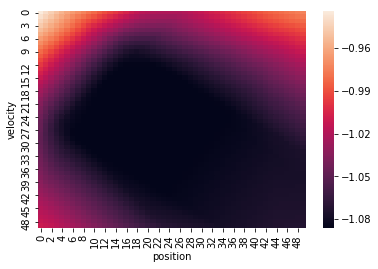

In [28]:
import seaborn as sns
import matplotlib.pylab as plt
from matplotlib.ticker import FormatStrFormatter

with torch.no_grad():
    pv_returns = np.array([[reward.cum_return(torch.from_numpy(np.array([[p,v]])).float()).item() for p in np.linspace(0,1)]
                           for v in np.linspace(0,1)])
print(pv_returns)
#uniform_data = np.array([[0,1,2],[4,3,2],[-1,-2,-10]])
#ax = sns.heatmap(uniform_data)
ax = sns.heatmap(pv_returns)

print(pv_returns.shape)

plt.xlabel("position")
plt.ylabel("velocity")
plt.savefig("learned_mcar_return.png")
plt.show()


Okay. So now we want to optimize a policy using the learned reward to see how well it can perform if we run RL to convergence on it.

In [29]:
#class that makes a reward function out of a neural network
class NNetReward:
    def __init__(self,nnet):
        self.nnet = nnet
    def get_reward(self, state):
        #transform to tensor and input to nnet
        return self.nnet.cum_return(torch.from_numpy(np.array([state])).float()).item()
        

In [32]:
#Run SARSA tilecoding on learned reward function
num_episodes = 1500

numOfTilings = 8
alpha = 0.5
n = 1

nn_reward = NNetReward(reward)


# use optimistic initial value, so it's ok to set epsilon to 0
EPSILON = 0.0
discount = 0.999 #using high discount factor

apprenticeVFunction = ValueFunction(alpha, numOfTilings)
for i in range(num_episodes):
    if i % 100 == 99:
        print(i, steps)
    r, s, steps = run_episode(env, apprenticeVFunction, n, False, EPSILON, max_time = 2000, reward_fn = nn_reward)
    
print("done training")
    


99 159
199 141
299 111
399 105
499 86
599 109
699 141
799 106
899 102
999 158
1099 94
1199 86
1299 144
1399 113
1499 147
1599 106
1699 108
1799 137
1899 156
1999 107


In [34]:
#evaluate the learned policy
returns = evaluate_policy(env, 200, apprenticeVFunction)
print("best, worst, average", np.max(returns), np.min(returns), np.mean(returns))

best, worst, average -83.0 -181.0 -103.755


In [36]:
print("evaluate demonstrations")
demo_returns = learning_returns

print("best worst, average", np.max(demo_returns), np.min(demo_returns), np.mean(demo_returns))

evaluate demonstrations
best worst, average -393.0 -2000.0 -800.4
